# Методы восстановления регрессии

Задачу обучения по прецедентам при $Y=\mathbb{R}$ принято называть задачей восстановления регрессии. Задано пространство объектов X и множество возможных ответов Y. Существует неизвестная целевая зависимость $y^*:X\rightarrow Y$ , значения которой известны только на объектах обучающей выборки $X^\ell = (x_i, y_i)_{i-1}^\ell, y_i = y^* (x_i)$. Требуется построить алгоритм, который в данной задаче принято называть "функцией регрессии" $a: X^* \rightarrow Y$ , аппроксимирующий целевую зависимость $y^*$.

 ## Непараметрическая регрессия: ядерное сглаживание
 
 Для начала установим внешние зависимости:

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plot

%matplotlib inline

Обучающую выборку сгенирируем сами на основе функции синуса, и добавим к нему шум, чтобы данные были более "реалистичными".
Возьмем синус от $-2\Pi$ до $4\Pi$, размер выборки 100, шум 0.2.

In [2]:
import regression.datasets as datasets

size = 100
data = datasets.sin_with_noise(-2 * np.pi, 4 * np.pi, size, noise=0.3)
xl, yl = data['xl'], data['yl']

Получили следующую выборку:

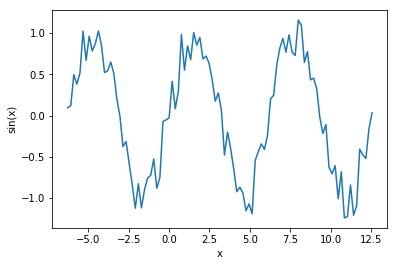

In [3]:
plot.plot(xl, yl)
plot.xlabel('x')
plot.ylabel('sin(x)')
plot.show()

### Формула Надарая–Ватсона
Возьмём самую простую модель регрессии, какая только возможна – константу $g(x, \alpha) = \alpha, \alpha \in \mathbb{R}$. Но при этом, чтобы не получить тривиального решения, введём веса объектов $w_i(x)$, зависящие от того объекта $x$, в котором мы собираемся вычислять значение $a(x) = g(x, \alpha)$. Можно сказать и так, что обучение регрессионной модели будет производиться отдельно в каждой точке $x$ пространства объектов $X$.

Зададим веса $w_i$ обучающих объектов так, чтобы они убывали по мере увеличения расстояния $\rho(x, x_i)$. Для этого введём невозрастающую, гладкую, ограниченную функцию $K$, называемую ядром.
Для непараметрической регрессии обычно используют 2 типа ядер: **гаусовское** и **квартическое**. Наша задача их сравнить.

In [4]:
def gauss(r):
    return (2 * math.pi) ** -0.5 * math.exp(-0.5 * r ** 2)

def quartic(r):
    return 15/16 * (1 - r ** 2) ** 2 * _sign(math.fabs(r) <= 1)

def _sign(condition):
    return 1 if condition else 0

Для вычисления предполагаемого ответа алгоритма в точке $x$ применим формулу Надарая-Ватсона:

In [5]:
from regression.utils import distance

def nw_regression(x, xl, yl, h, kernel):
    top, bottom = 0, 0
    for i, x_i in enumerate(xl):
        k = kernel(distance(x, x_i) / h)
        top += yl[i] * k
        bottom += k

    return float('inf') if bottom == 0 else top / bottom

Для определения оптимальной ширины окна _h_ нужно подобрать параметр с помощью *метода наименьших квадратов*

In [6]:
def loo(xl, yl, hl, kernel):
    h_errors = []

    for h in hl:
        h_error = 0
        for i, x in enumerate(xl):
            y_r = nw_regression(x, np.delete(xl, i), np.delete(yl, i), h, kernel)
            h_error += (y_r - yl[i]) ** 2
        h_errors.append(h_error)

    return h_errors

Для тестирования показателей алгоритма при разных ядрах подготовим функцию:
1. Пропускаем массив предполагаемых значений окон *hl* через _LOO_, чтобы выбрать окно с наименьшей ошибкой.
2. Для наилучшего окна вычисляем значения регрессии.
3. Выводим результат
4. Возвращаем ошибки для дальнейшего анализа.

In [7]:
def test_by_kernel(kernel, hl):
    # 1
    h_errors = loo(xl, yl, hl, kernel)
    
    # 2
    min_i = np.argmin(h_errors)
    h_error = round(h_errors[min_i], 5)
    best_h = round(hl[min_i], 1)
    yl_r = list(map(lambda x: nw_regression(x, xl, yl, best_h, kernel), xl))
    
    # 3
    plot.plot(xl, yl)
    plot.plot(xl, yl_r)
    plot.xlabel('x, h = ' + str(best_h))
    plot.ylabel('sin(x), mistake = ' + str(h_error))
    plot.show()
    
    #4
    return h_errors

Протестируем и сравним 2 ядра.
Для этого вначале создадим массив тестируемых значений ширины окна *h*, чтобы выбрать из них окно с меньшей ошибкой. Окна будем брать от 0.1 до 1.5 с шагом 0.05:

In [8]:
hl = np.arange(0.1, 1.5, 0.05)

1. **Гауссовское ядро**

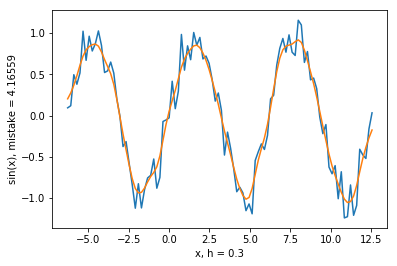

In [12]:
h_gauss_errors = test_by_kernel(gauss, hl)

2. **Квартическое ядро**

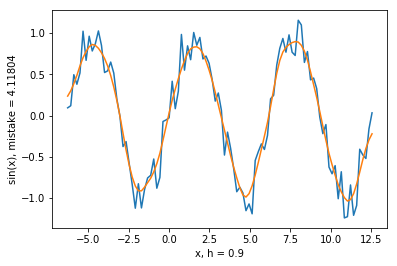

In [13]:
h_quartic_errors = test_by_kernel(quartic, hl)

Выведем SSE регрессии при различной ширине окна для сравнения ядерного сглаживания:

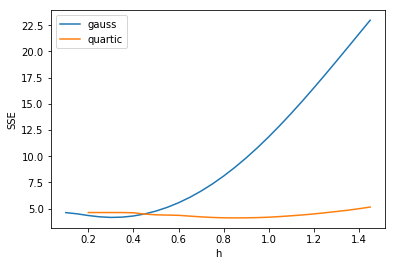

In [14]:
plot.plot(hl, h_gauss_errors)
plot.plot(hl, h_quartic_errors)
plot.legend(['gauss', 'quartic'])
plot.xlabel('h')
plot.ylabel('SSE')
plot.show()

Как показали тесты, ядра на качество регрессии при правильно подобранной ширине окна почти не влияют. Однако, у каждого ядра оптимальная ширина окна своя. И за счет того, что гаусовское ядро бесконечное, оно сильно теряет в качестве при увеличении ширины окна, в отличие от квартического.